# Understanding the Amazon rainforest from space

Overview of Assignment
There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [1]:
##Create Libraries [Requires cleaning]
### Required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter, defaultdict
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import random
# from osgeo import gdal
from skimage import io
#import imageio
from spectral import get_rgb
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


D:\Applications\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

D:\Applications\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



## Read the Satellite Images
There're 2 image formats provided for training and testing: jpg and tif. The tif format contains additional dimensions outside of the jpg RGB dimensional constraints which enable us to extract the infrared spectrum.

In [2]:
##set path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'

#obtain training labels
df = pd.read_csv('train_labels.csv')

#retrieve jpg data - compress from 256x256 to 64x64 for faster training [remove constraint in final product]
data_jpgs=np.zeros((40000,64,64,3))

##retrieve jpg data
def read_image(image_str):
    read_img = plt.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    jpg_img=transform.resize(read_img, (64,64,3))
    return jpg_img
for i in range(40000):
    data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")

In [3]:
#retrieve tif format satellite images - compress from 256x256 to 64x64 for faster training [remove constraint in final product]
def extract_identifier(image_str):
    read_img = io.imread(train_path2+image_str)
    tif_img=transform.resize(read_img, (64,64,4))
    return tif_img

#4th dimension of GeoTiff contains near-infrared spectrum
tif_data=np.zeros((40000,64,64,4))
for i in range(40000):
    tif_data[i,:,:,:]=extract_identifier("train_"+str(i)+".tif")

## Label Analysis, Visualization, & Correlation

Each picture can have multiple labels. There is a varying visibility between the images.  

As a result, visibility is a key feature which needs to be identified and cleared for additional feature identification. Visibility is categorized in levels by cloud cover - haze, partly cloudy, cloudy and clear.

Primary label refers to primary rainforest. Water refers to rivers and large water bodies.

Human interference & civilization can be categorized into road, agriculture, habitation, selective logging, artisal mine, slash burn, blow down, conventional mine, etc.

Since the goal of our project is to automatically categorize landscape, which prepares for the prediction of rainforest diminishing rate, we categorize the original labels into three main areas:
* Weather due to cloud cover (haze, partly cloudy, haze)
* Road/water
* Primary
* Other tags

All other tags will be removed to reduce the complexity.


In [4]:
#Add a column for land tags
def apply_land(land_tags):
    if 'primary' in land_tags:
        return 'primary'
    elif 'water' in land_tags:
        return 'water'
    else:
        return 'other'
df['land'] = df.tags.map(apply_land)
df_tags = df['land'].tolist()

#Add a column to remove tags that are harder to predict
def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

#Add a column for weather tags
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)
df_tags = df['weather'].tolist()

In [5]:
#After adding three more columns, our dataframe looks like this
print(df.iloc[:3])

  image_name                             tags     land  \
0    train_0                     haze primary  primary   
1    train_1  agriculture clear primary water  primary   
2    train_2                    clear primary  primary   

                      simpler_tags weather  
0                     haze primary    haze  
1  agriculture clear primary water   clear  
2                    clear primary   clear  


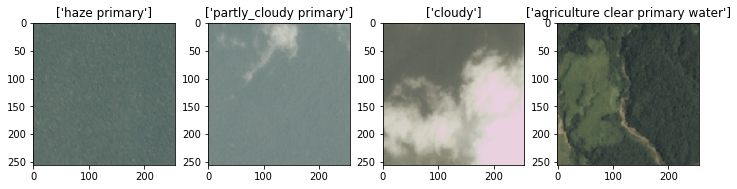

In [6]:
#Graph demonstration of four weather type
plt.figure(figsize=(12,12))
weather_list = ["haze","partly_cloudy","cloudy","clear"]
j = 0
for i in weather_list:
    plt.subplot(4,4,j+1)
    image_number = df.loc[df['weather'] == i][:1]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

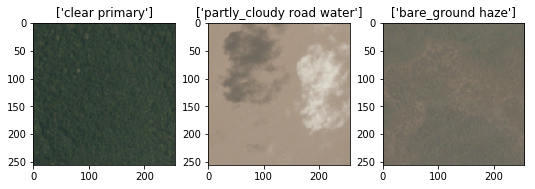

In [7]:
#Graph demonstration of three land type
plt.figure(figsize=(12,12))
land_list = ["primary","water","other"]
j = 0
for i in land_list:
    plt.subplot(4,4,j+1)
    image_number = df.loc[df['land'] == i][3:4]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.title(str(df[df.image_name == image_number[0]].tags.values))  
    j += 1

### Observation
Image visibility varies. Images with out haze and cloud are much easier to identify the land type. 

Each picture has multiple labels except for 'Cloudy' tag, which does not appear with other labels. 'Water' is sometimes hard to identify in the images.

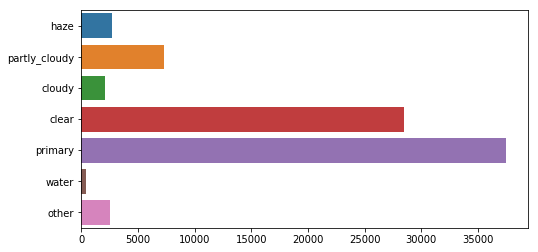

In [8]:
#Display counts of weather and land labels
df["combined_tags"] = df["weather"] + " " + df["land"]
labels = df['combined_tags'].apply(lambda x: x.split(' '))
all_tags = [item for sublist in list(labels.values) for item in sublist]
labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=labels_s, y=labels_s.index, orient='h', order = ['haze', 'partly_cloudy', 'cloudy', 'clear','primary', 'water', 'other'])

### Observation
The majority pictures have 'Clear' weather and 'Primary' land type. 

There are very few pictures have the 'Water' tag.

In [9]:
#Display correlation between labels 
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=600, width=600, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

### Observation

'Primary' land type has high correlation with all weather tags except for "Cloudy". Most "Cloudy" pictures have "Other" land type. 

"Water" land type is highly correlated with "Clear" tag.

Static features including volume of colours can be extracted using the following logic:
* Green = Trees/Vegetation
* Blue = Water
* White = Clouds

The higher the pixel value, the higher the intensity of the colors. Variance in the colors indicate feature differences in the image.

In [12]:
##extract_basic-stats about image
stats_flat=np.reshape(data_jpgs,(data_jpgs.shape[0],4096,3))
jpg_stats=np.zeros((stats_flat.shape[0],75))
for i in range(stats_flat.shape[0]):
    jpg_stats[i,0:3]=np.average(stats_flat[i],axis=0)
    jpg_stats[i,3:6]=np.var(stats_flat[i],axis=0)
    jpg_stats[i,6:9]=np.std(stats_flat[i],axis=0)
    kurt_skew=np.zeros((6,))
    
    for j in range(3):
        kurt_skew[j]=scipy.stats.kurtosis(data_jpgs[i,:,:,j].ravel())
        kurt_skew[j]=scipy.stats.skew(data_jpgs[i,:,:,j].ravel())
    jpg_stats[i,9:15]=kurt_skew
    jpg_stats[i,15:35]=np.array(np.histogram(data_jpgs[1,:,:,0],bins=20, range=(0,1))[0])
    jpg_stats[i,35:55]=np.array(np.histogram(data_jpgs[1,:,:,1],bins=20, range=(0,1))[0])
    jpg_stats[i,55:75]=np.array(np.histogram(data_jpgs[1,:,:,2],bins=20, range=(0,1))[0])

The mean color intensity is:  0.32
The mean color variance is:  0.003
The mean color standard deviation is:  0.043


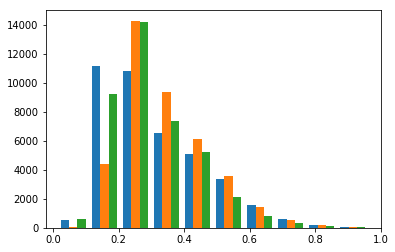

In [19]:
print('The mean color intensity is: ', round(jpg_stats[:,0:3].mean(), 2))
plt.hist(jpg_stats[:,0:3])
print('The mean color variance is: ', round(jpg_stats[:,3:6].mean(), 3))
print('The mean color standard deviation is: ', round(jpg_stats[:,6:9].mean(), 3))


Edge detection in the images can be analyzed using the following parameters:
* Laplacian outputs the color gradients in the images
* Sobel outputs the edges of the color gradients in the x or the y directions

The following distributions shows that majority of the pictures may not have large color gradients. As a result, many of the images are dominated by their respective label components and relatively few satellite images contain edges.

In [20]:
##extract edge data from images
edge_stats=np.zeros((stats_flat.shape[0],6))
for i in range(stats_flat.shape[0]):
    edge_stats[i,0]=cv2.Laplacian(data_jpgs[i], cv2.CV_64F).mean()
    edge_stats[i,1]=cv2.Laplacian(data_jpgs[i], cv2.CV_64F).var()
    edge_stats[i,2]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,1,0,ksize=5).var()
    edge_stats[i,3]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,1,0,ksize=5).mean()
    edge_stats[i,4]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,0,1,ksize=5).mean()
    edge_stats[i,5]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,0,1,ksize=5).var()

(array([2.0000e+00, 4.0000e+00, 4.8000e+01, 5.5900e+02, 1.8670e+04,
        2.0043e+04, 6.0500e+02, 6.5000e+01, 3.0000e+00, 1.0000e+00]),
 array([-2.18856911e-03, -1.75269831e-03, -1.31682751e-03, -8.80956712e-04,
        -4.45085912e-04, -9.21511183e-06,  4.26655688e-04,  8.62526488e-04,
         1.29839729e-03,  1.73426809e-03,  2.17013889e-03]),
 <a list of 10 Patch objects>)

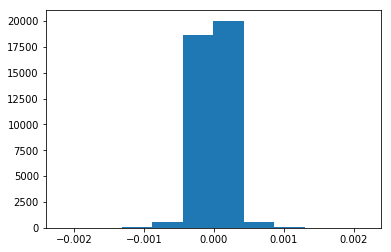

In [26]:
plt.hist(edge_stats[:,0])

(array([1.0000e+00, 9.0000e+00, 7.9000e+01, 3.6600e+02, 3.4070e+03,
        3.4277e+04, 1.5600e+03, 2.4400e+02, 5.0000e+01, 7.0000e+00]),
 array([-1.50888233, -1.22762907, -0.9463758 , -0.66512254, -0.38386928,
        -0.10261601,  0.17863725,  0.45989051,  0.74114377,  1.02239704,
         1.3036503 ]),
 <a list of 10 Patch objects>)

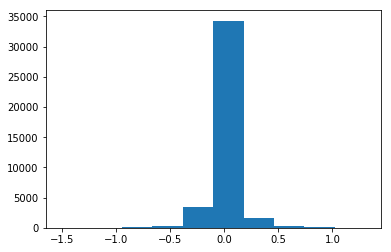

In [30]:
plt.hist(edge_stats[:,3:4])

## Split training and test sets [jpg]
The first 30000 samples will be allocated to the training set while the remaining samples will be allocated to the test set. Randomization is not required since prior ordering is unknown.

In [53]:
print(df)
train_labels_jpgs=np.array(df_tags[:30000])

train_data_jpgs=np.zeros((len(train_labels_jpgs),64,64,3))
for i in range(len(train_labels_jpgs)):
    train_data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")


test_labels_jpgs=np.array(df_tags[30000:])

test_data_jpgs=np.zeros((len(test_labels_jpgs),64,64,3))
for i in range(len(test_labels_jpgs)):
    test_data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")

        image_name                                               tags  \
0          train_0                                       haze primary   
1          train_1                    agriculture clear primary water   
2          train_2                                      clear primary   
3          train_3                                      clear primary   
4          train_4          agriculture clear habitation primary road   
5          train_5                                 haze primary water   
6          train_6        agriculture clear cultivation primary water   
7          train_7                                       haze primary   
8          train_8              agriculture clear cultivation primary   
9          train_9         agriculture clear cultivation primary road   
10        train_10         agriculture clear primary slash_burn water   
11        train_11                                clear primary water   
12        train_12                                 

## Infrared spectrum analysis

Extracting the near-infrared spectrum in the images(tif format) enables the identification of "hot" surfaces with varying degrees of heat such as: 
1. Civilization
2. Vegetation
3. Large bodies of water

Water features can be identified by removing the blue frequency from the near-infrared spectrum: (B-IRR)/(B+IRR) 

Vegetation features can be identified by removing green frequency from the near-infrared spectrum: (IRR-R)/(R+IRR)

In [47]:
#extract, vegetation probabilities and water information - show how the data
#This take the blue pixels, subtracts the infrared, and divides by the total to indicate water
water_tif=(tif_data[:,:,:,0]-tif_data[:,:,:,3])/(tif_data[:,:,:,0]+tif_data[:,:,:,3])
#This take the infrared pixels, subtracts the red, and divides by the total to indicate vegetation
veg_tif=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 

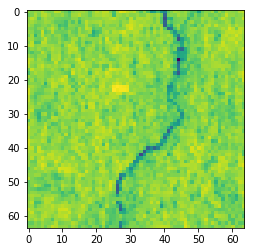

In [46]:
#Sample vegetation feature identification
plt.imshow(veg_tif[18573])

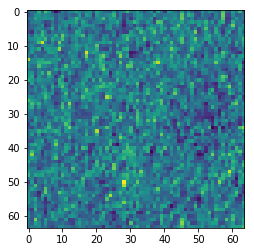

In [49]:
#Sample water feature identification
plt.imshow(water_tif[10000])

In [32]:
veg_props=np.zeros((40000,10))
for i in range(40000):
    #this calculates the ditribution of the index. Lots of values near one indicate lots of trees, 
    #values between 0-0.4 indicate bare ground
    veg_props[i,:]=np.array(np.histogram(veg_tif[i],bins=10, range=(-1,1))[0])
water_props=np.zeros((40000,10))
for i in range(40000):
    water_props[i,:]=np.array(np.histogram(water_tif[i],bins=10, range=(-1,1))[0])

In [33]:
combined_matrix=np.zeros((40000,101))
combined_matrix[:,0:10]=veg_props
combined_matrix[:,10:20]=water_props
combined_matrix[:,20:95]=jpg_stats
combined_matrix[:,95:101]=edge_stats

## Split training and test sets [tif]
The first 30000 samples will be allocated to the training set while the remaining samples will be allocated to the test set. Randomization is not required since prior ordering is unknown.

In [51]:
#Create test and training datatrain_labels=np.array(df_tags[:30000])
train_labels=np.array(df_tags[:30000])
train_data=combined_matrix[:30000]

test_labels=np.array(df_tags[30000:40000])
test_data=combined_matrix[30000:]

## Principal component analysis (PCA)

PCA speeds up the training of features by choosing the minimum number of components such that 95% of the variance is retained.

A logistic regression model is used to further examine the prediction score.

In [43]:
#PCA the training set to potentially reduce the size
pca = PCA(.95)
pca.fit(train_data)

train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

print('The PCA explained variance ratios for each component are: ', pca.explained_variance_ratio_)
print('The number of PCA components chosen are: ', pca.n_components_)


#Testing accuracy of logistic Regression with PCA for sample of 1000 images
logisticRegr = LogisticRegression(solver = 'lbfgs')
%time logisticRegr.fit(train_data, train_labels)
logisticRegr.predict(test_data[0:1000])
print('The logistic regression score is:', logisticRegr.score(test_data, test_labels))


The PCA explained variance ratios for each component are:  [0.59032854 0.25317805 0.08603829 0.07045513]
The number of PCA components chosen are:  4
CPU times: user 1.25 s, sys: 60.6 ms, total: 1.31 s
Wall time: 338 ms
The logistic regression score is: 0.7105


## Weather feature identification

Weather feature identification is being performed for cloud and haze removal. This facilitates the successive water, land and primary feature identification.

In [78]:
#Logistics Regression
model_LG =LogisticRegression()
model_LG.fit(train_data, train_labels)
LG_predictions=model_LG.predict(test_data)
print(classification_report(test_labels,LG_predictions))

               precision    recall  f1-score   support

        clear       0.78      0.95      0.86      7023
       cloudy       0.67      0.38      0.48       493
         haze       0.58      0.09      0.16       676
partly_cloudy       0.64      0.38      0.48      1808

  avg / total       0.74      0.76      0.72     10000



In [77]:
def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=20, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50,100]:
    print("K-branch levels" + str(i))
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

               precision    recall  f1-score   support

        clear       0.89      0.94      0.91      7023
       cloudy       0.72      0.59      0.65       493
         haze       0.60      0.62      0.61       676
partly_cloudy       0.79      0.64      0.71      1808

  avg / total       0.84      0.85      0.84     10000

               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      7023
       cloudy       0.74      0.70      0.72       493
         haze       0.71      0.59      0.65       676
partly_cloudy       0.82      0.74      0.78      1808

  avg / total       0.87      0.88      0.87     10000

               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      7023
       cloudy       0.75      0.70      0.72       493
         haze       0.71      0.56      0.63       676
partly_cloudy       0.81      0.75      0.78      1808

  avg / total       0.87      0.88      0.87     10000

 

In [86]:
def random_forest_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = RandomForestClassifier(n_estimators=20, max_depth=maxs, min_samples_split=2, min_samples_leaf=5)
     #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50]:
    print("K-branch levels" + str(i))
    print(random_forest_model(i,train_data,train_labels,test_data,test_labels))

K-branch levels5
               precision    recall  f1-score   support

        clear       0.85      0.97      0.91      7023
       cloudy       0.72      0.58      0.64       493
         haze       0.72      0.44      0.55       676
partly_cloudy       0.85      0.53      0.65      1808

  avg / total       0.83      0.84      0.82     10000

K-branch levels10
               precision    recall  f1-score   support

        clear       0.90      0.98      0.94      7023
       cloudy       0.77      0.74      0.75       493
         haze       0.79      0.56      0.66       676
partly_cloudy       0.88      0.71      0.78      1808

  avg / total       0.88      0.89      0.88     10000

K-branch levels20
               precision    recall  f1-score   support

        clear       0.92      0.97      0.94      7023
       cloudy       0.77      0.76      0.76       493
         haze       0.78      0.57      0.66       676
partly_cloudy       0.88      0.76      0.81      1808

  av

In [93]:
sel_weather_model = RandomForestClassifier(n_estimators=10, max_depth=50, min_samples_leaf=20)
     #fit per the train data
sel_weather_model.fit(train_data, train_labels)
dev_predictions2=model.predict(test_data)
print(classification_report(test_labels,dev_predictions2))
print(confusion_matrix(test_labels,dev_predictions2))

               precision    recall  f1-score   support

        clear       0.91      0.97      0.94      7023
       cloudy       0.78      0.75      0.77       493
         haze       0.78      0.58      0.67       676
partly_cloudy       0.89      0.75      0.81      1808

  avg / total       0.89      0.90      0.89     10000

[[6841   22   59  101]
 [  37  372   36   48]
 [ 197   61  395   23]
 [ 409   23   19 1357]]


This is a fairly accurate model, but too much of partly cloudly and hazy is getting classified as clear. We might need
to split the colour bands up more, to be able to separate the from clear.

Lets try the simple tags and see how we do.

In [18]:
df['tags_split'] = df['simpler_tags'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['tags_split'])

train_labels=labels[:30000]

test_labels=labels[30000:40000]


In [26]:
#let's try a decision trees, model
ovr=OneVsRestClassifier(DecisionTreeClassifier(max_depth=50, min_samples_leaf=20)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))


             precision    recall  f1-score   support

          0       0.76      0.70      0.73      3020
          1       0.54      0.11      0.19       244
          2       0.00      0.00      0.00         1
          3       0.92      0.94      0.93      7023
          4       0.75      0.68      0.71       493
          5       0.44      0.22      0.30      1127
          6       0.48      0.27      0.35       917
          7       0.74      0.52      0.61       676
          8       0.80      0.74      0.77      1808
          9       0.98      0.98      0.98      9291
         10       0.61      0.52      0.56      1974
         11       0.74      0.59      0.66      1807

avg / total       0.84      0.79      0.81     28381



In [27]:
#let's try a random forest, model
ovr=OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_depth=50, min_samples_leaf=20)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))



             precision    recall  f1-score   support

          0       0.82      0.67      0.74      3020
          1       0.00      0.00      0.00       244
          2       0.00      0.00      0.00         1
          3       0.91      0.96      0.93      7023
          4       0.80      0.67      0.73       493
          5       0.74      0.07      0.12      1127
          6       0.81      0.13      0.22       917
          7       0.81      0.49      0.61       676
          8       0.88      0.70      0.78      1808
          9       0.97      0.99      0.98      9291
         10       0.72      0.46      0.56      1974
         11       0.85      0.52      0.64      1807

avg / total       0.88      0.77      0.80     28381



The model does well at picking clear, cloudy, primary and not much else. To better identify roads, and water edge extraction may 
help. We're also not taking advantage of correlation with the model here.

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we need to build more features to pick up land masses, roads and waters. 


## Feature prediction of clear components
Land and water can be extracted using canny edge detection or equivalent. The inputs are haze/cloud cleared train data+labels.

[Under construction]

In [ ]:
def road_water_canny(train_data, train_labels, test_data, test_labels):
##Testing water/road feature identification##
    #40479 images in df
    #13357 images with water and road tags in labels
    train_roadwater_data = [i for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    train_roadwater_labels = [j for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    

    
    train_images = []
    test_images = []
    
    feature_count = 0
    positive_test_img = []
    plt.figure(figsize=(12,12))
    
    for i, train_img in enumerate(train_roadwater_data):
        
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cannyed_image = cv2.Canny(gray_image, 100, 200)
        
        try:
            plt.subplot(3,3,i+1)
            if i < 10:
                plt.imshow(cannyed_image)
                #plt.title(str(df[df.image_name == df_road_water_images[i]].tags.values))
        except:
            pass
        
        predicted_sum = sum(cannyed_image.flatten())
        
        if predicted_sum > 2.0:
            feature_count += 1
            positive_train_img.append(train_)
        
    positive_label_count = len([i for i, j in zip(train_roadwater_, positive_train_img) if i == j])
    
    return feature_count, positive_label_count
    
feature_count, positive_label_count = road_water_canny(df)
print('Total number of images with water/road boundary features', feature_count)
print('Correctly predicted labels', positive_label_count)
print('Accuracy is: ', positive_label_count/feature_count * 100, '%')
print('Remaining images with especially water labels may not have boundaries/features in water or contain too much cloud.')

Going forward we've got three clear priorities:

Improve the models we have now:
1) Improve the classifiers we have by running cross validation on the data, and setting up proper pipelines
2) Play with the statistics in the model to see if changing them produces better impacts (i.e. water prediction is only working a third of the time, can we improve it)
3) Try other kinds of multi-label models

Extract More features:
1) We've used a haze remover before to improve picture quality, and a two stage process will let us identify which pictures need it and then extract the land labels so we don't use any information.

Try Deep learning:
Image feature analysis is some what out of fashion, and most of the successful approaches to this on Kaggle used CNN. 
June if you could point us in the right direction for how to do this that would be awesome. We've run into memory issues, before using the statistical extraction approach.

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up